### Project Objectives

A large supermarket chain has collected data regarding its product sales across 10 of its stores. 

Using machine learning regression methods, the objective is to predict the future sales of all products sold by the supermarket.

In [1]:
from pyforest import*

In [2]:
lazy_imports()

['import pydot',
 'from openpyxl import load_workbook',
 'import pandas as pd',
 'import matplotlib.pyplot as plt',
 'from sklearn.ensemble import GradientBoostingRegressor',
 'from pathlib import Path',
 'from sklearn.feature_extraction.text import TfidfVectorizer',
 'import spacy',
 'import sys',
 'import plotly.graph_objs as go',
 'import numpy as np',
 'import seaborn as sns',
 'from dask import dataframe as dd',
 'import plotly.express as px',
 'import nltk',
 'from sklearn.ensemble import RandomForestRegressor',
 'import tensorflow as tf',
 'import awswrangler as wr',
 'import os',
 'import datetime as dt',
 'import altair as alt',
 'from pyspark import SparkContext',
 'import gensim',
 'import plotly as py',
 'from sklearn.preprocessing import OneHotEncoder',
 'from sklearn.model_selection import train_test_split',
 'import xgboost as xgb',
 'import lightgbm as lgb',
 'import dash',
 'import re',
 'import tqdm',
 'import matplotlib as mpl',
 'import keras',
 'from sklearn import

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
training_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
training_set.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
test_set.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [7]:
print("Training set dimensions:", training_set.shape)
print("Test set dimensions:", test_set.shape)
# Note that the testing set is missing the explanatory variate

Training set dimensions: (8523, 12)
Test set dimensions: (5681, 11)


In [8]:
training_set.describe().T # Summary statistics for our training data

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


### Data Preprocessing

In [9]:
training_set.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
test_set.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [11]:
training_set["source"] = "training"
test_set["source"] = "test"
dataset = pd.concat([training_set, test_set], ignore_index = True)

<IPython.core.display.Javascript object>

In [12]:
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,training
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,training
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,training
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,training
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,training


In [13]:
dataset.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

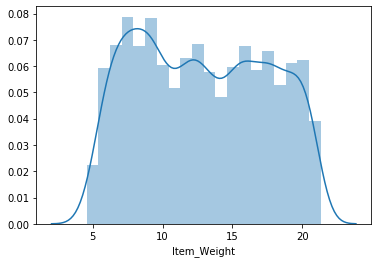

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

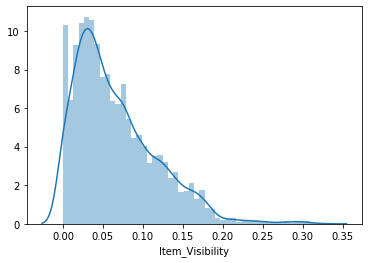

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

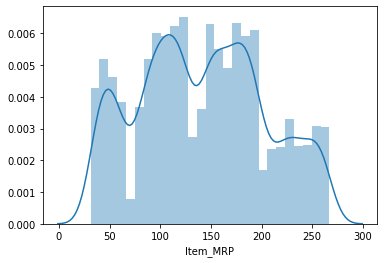

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

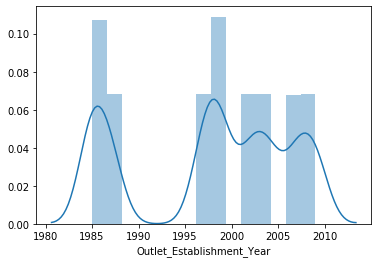

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

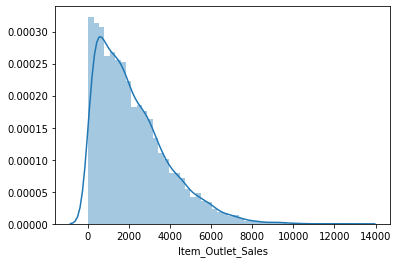

In [14]:
for i in training_set.describe().columns:
    sns.distplot(training_set[i].dropna())
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

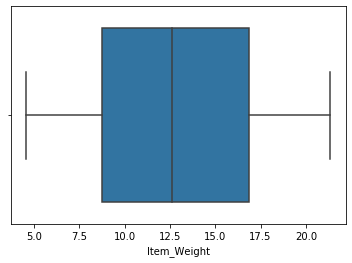

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

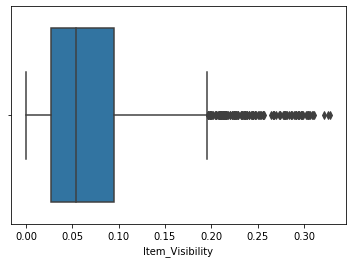

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

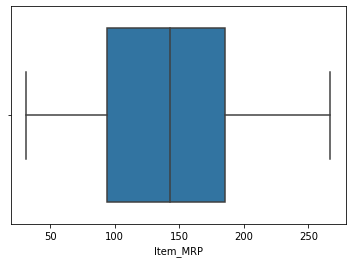

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

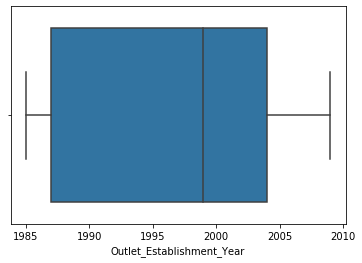

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

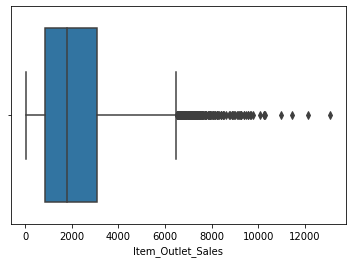

In [15]:
for i in training_set.describe().columns:
    sns.boxplot(training_set[i].dropna())
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

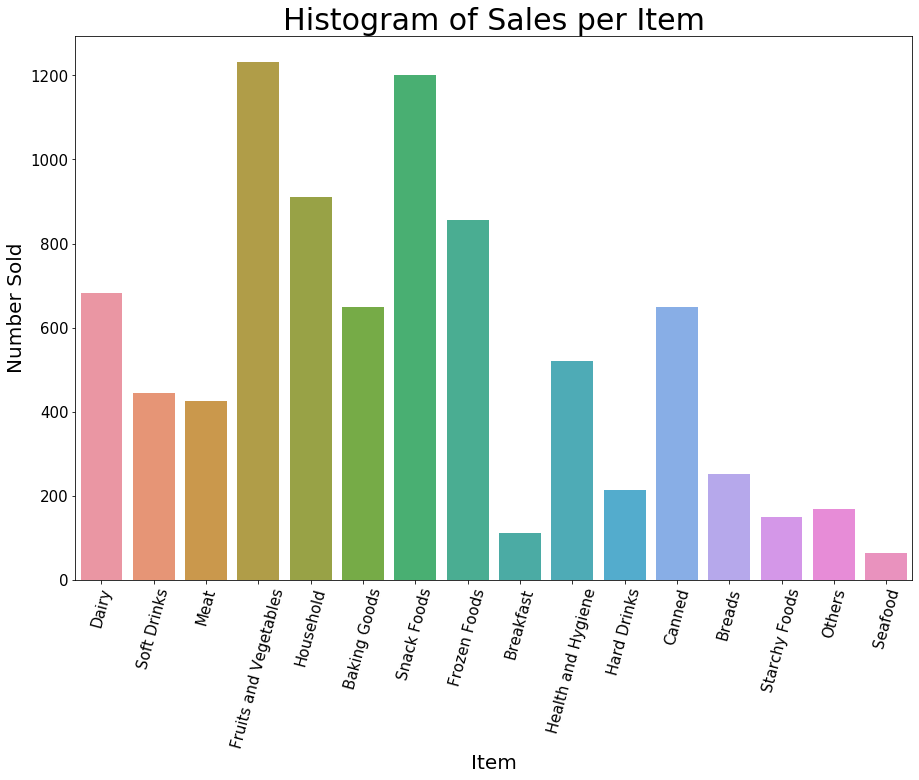

In [16]:
plt.figure(figsize = (15, 10))
sns.countplot(training_set.Item_Type)
plt.xticks(rotation = 75, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Histogram of Sales per Item", fontsize = 30)
plt.xlabel("Item", fontsize = 20)
plt.ylabel("Number Sold", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

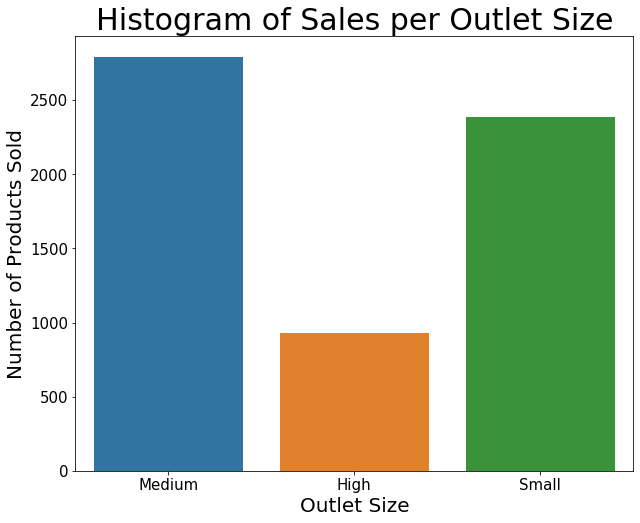

In [17]:
plt.figure(figsize = (10, 8))
sns.countplot(training_set.Outlet_Size)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Histogram of Sales per Outlet Size", fontsize = 30)
plt.xlabel("Outlet Size", fontsize = 20)
plt.ylabel("Number of Products Sold", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

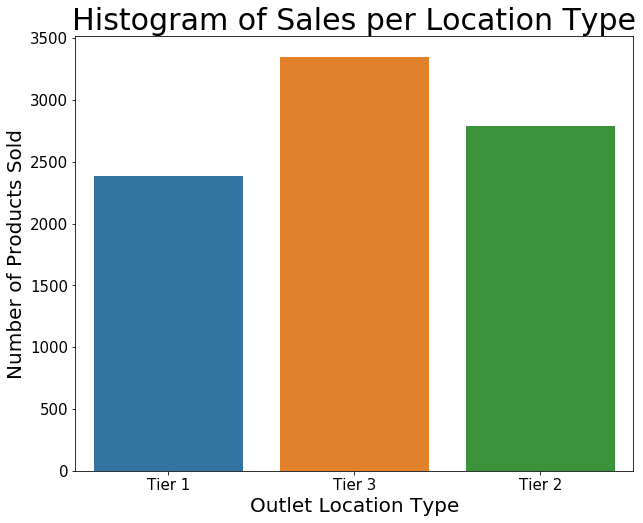

In [18]:
plt.figure(figsize = (10, 8))
sns.countplot(training_set.Outlet_Location_Type)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Histogram of Sales per Location Type", fontsize = 30)
plt.xlabel("Outlet Location Type", fontsize = 20)
plt.ylabel("Number of Products Sold", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

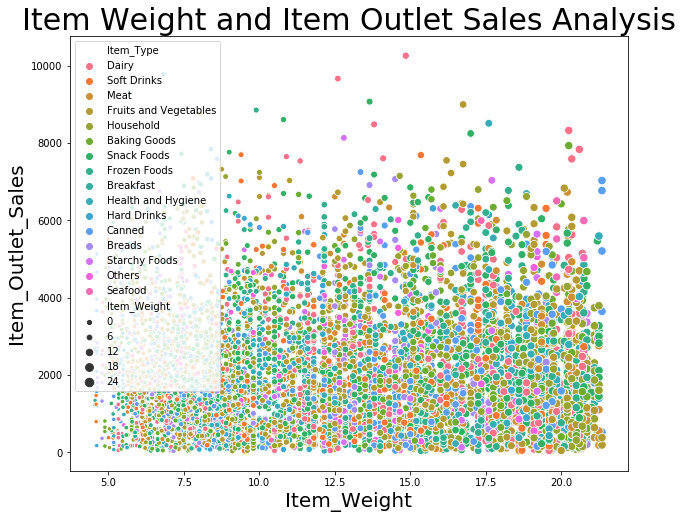

In [19]:
plt.figure(figsize = (10, 8))
plt.xlabel("Item Weight", fontsize = 20)
plt.ylabel("Item Outlet Sales", fontsize = 20)
plt.title("Item Weight and Item Outlet Sales Analysis", fontsize = 30)
sns.scatterplot(x = "Item_Weight", y = "Item_Outlet_Sales",
               hue = "Item_Type", size = "Item_Weight",
               data = training_set)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

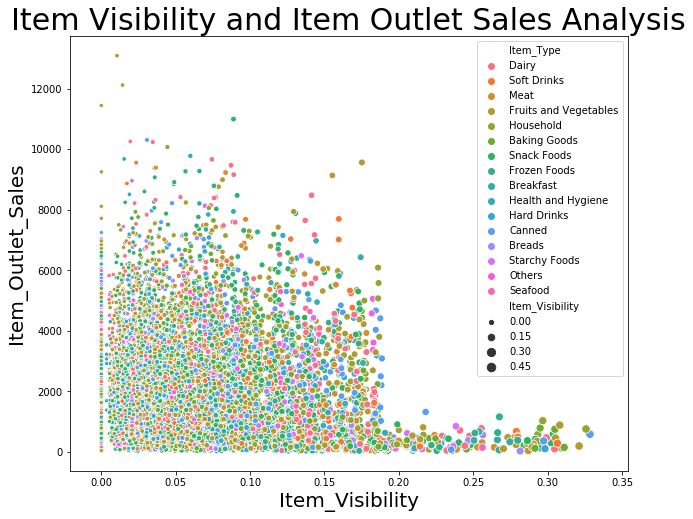

In [20]:
plt.figure(figsize = (10, 8))
plt.xlabel("Item Weight", fontsize = 20)
plt.ylabel("Item Outlet Sales", fontsize = 20)
plt.title("Item Visibility and Item Outlet Sales Analysis", fontsize = 30)
sns.scatterplot(x = "Item_Visibility", y = "Item_Outlet_Sales",
               hue = "Item_Type", size = "Item_Visibility",
               data = training_set)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

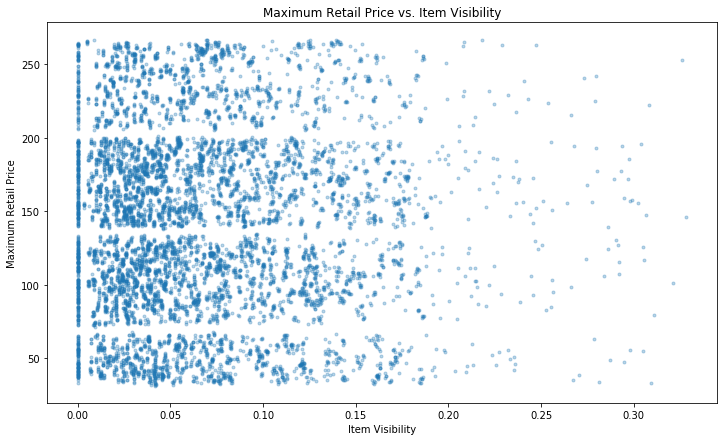

In [21]:
plt.figure(figsize = (12, 7))
plt.xlabel("Item Visibility")
plt.ylabel("Maximum Retail Price")
plt.title("Maximum Retail Price vs. Item Visibility")
plt.plot(training_set.Item_Visibility, training_set.Item_MRP, ".", alpha = 0.3)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

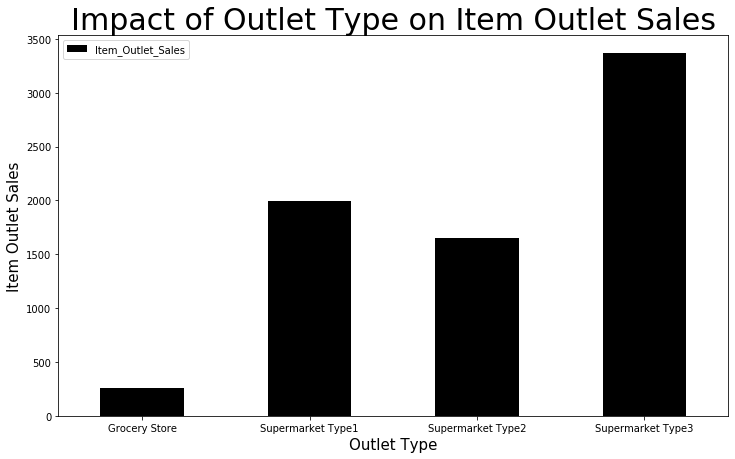

In [22]:
outlet_type_pivot = \
training_set.pivot_table(index = "Outlet_Type", values = "Item_Outlet_Sales",
                        aggfunc = np.median)
outlet_type_pivot.plot(kind = "bar", color = "black", 
                      figsize = (12, 7))
plt.xlabel("Outlet Type", fontsize = 15)
plt.ylabel("Item Outlet Sales", fontsize = 15)
plt.title("Impact of Outlet Type on Item Outlet Sales", fontsize = 30)
plt.xticks(rotation = 0)
plt.show()

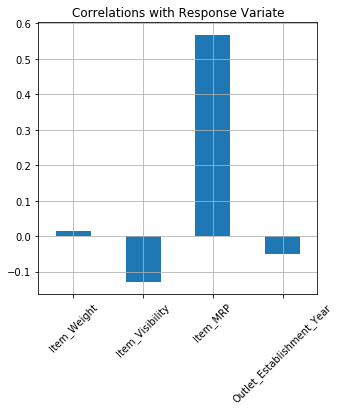

In [23]:
dataset2 = dataset.drop(columns = "Item_Outlet_Sales")
dataset2.corrwith(dataset["Item_Outlet_Sales"]).plot.bar(figsize = (5, 5),
                                             title = "Correlations with Response Variate", 
                                             fontsize = 10, rot = 45, grid = True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

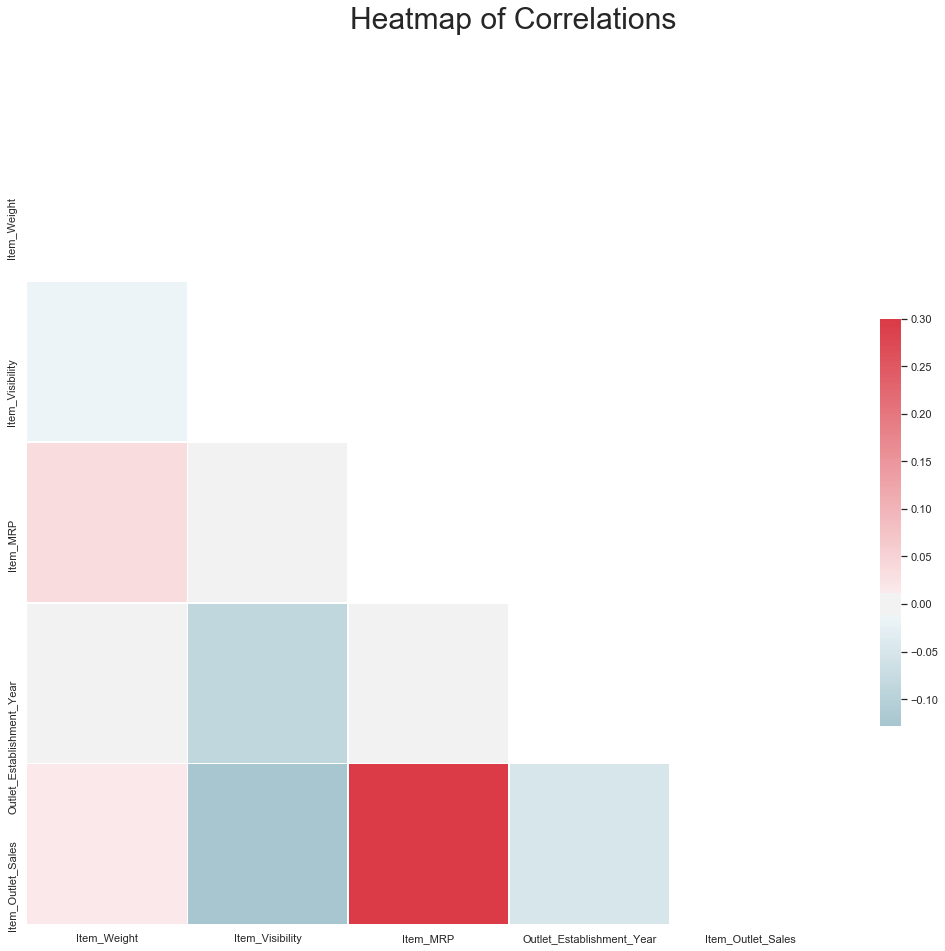

In [24]:
sns.set(style = "white")

corr = dataset.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (18, 15))

cmap = sns.diverging_palette(h_neg = 220, h_pos = 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidth = 0.5, cbar_kws = {"shrink": 0.5})
f.suptitle("Heatmap of Correlations", fontsize = 30)
plt.show()

### Feature Engineering, Selection & Transformation

#### NaN Values 

Recall that "Item_Weight" and "Outlet_Size" contain NaN values in both training and testing set. For the "Item_Weight", we will replace all NaN values with the mean item weight of all present values. This is because the Item Weight data is well approximated by a Gaussian distribution as seen in the EDA section.

In [25]:
dataset["Item_Weight"].fillna(dataset["Item_Weight"].mean(), inplace = True)

For the "Outlet_Size", we will be replacing all NaN values with "Medium" since it represents the modal value for this variate.

In [26]:
dataset["Outlet_Size"].fillna("Medium", inplace = True)

In [27]:
dataset.isna().sum() # We are good to go

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

The "Item_Visibility" has a minimum value of 0, as we can see from earlier EDA. However, a visibility of 0 does not make sense. Visibility of 0 should mean "not available". So for the purpose of our machine learning models, we will treat these 0 values as NaN. We will replace these values with the median item visibility, because the distribution is positively skewed.

In [28]:
dataset["Item_Visibility"].fillna(dataset["Item_Visibility"].median(), inplace = True)

We will also turn the "Outlet_Years" to descibe the age of the outlet as opposed to its year of establishment. Note that this dataset was compiled in 2010.

In [29]:
dataset["Outlet_Age"] = 2010 - dataset["Outlet_Establishment_Year"]
dataset["Outlet_Age"].describe()

count    14204.000000
mean        12.169319
std          8.371664
min          1.000000
25%          6.000000
50%         11.000000
75%         23.000000
max         25.000000
Name: Outlet_Age, dtype: float64

#### Item Identifier

There are currently 16 item identifiers. To simplify the process for our machine learning models, we will break down these 16 identifiers into one of 3 categories: drinks, non-consumable or food. Note that if a product is non-consumable, there is no need to associate a fat-content to it.

In [30]:
dataset["New_Item_Type"] = dataset["Item_Identifier"].apply(lambda x: x[0:2])
dataset["New_Item_Type"] = dataset["New_Item_Type"].map({"FD":"Food", "NC": "Non-Consumable", "DR": "Drinks"})
dataset["New_Item_Type"].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: New_Item_Type, dtype: int64

In [31]:
dataset.loc[dataset["New_Item_Type"] == "Non-Consumable", "Item_Fat_Content"] = "Non-Consumable"
dataset.loc[dataset["Item_Fat_Content"] == "LF"] = "Low Fat"
dataset.loc[dataset["Item_Fat_Content"] == "low fat"] = "Low Fat"
dataset.loc[dataset["Item_Fat_Content"] == "reg"] = "Regular"
dataset["Item_Fat_Content"].value_counts()

Low Fat           6499
Regular           5019
Non-Consumable    2686
Name: Item_Fat_Content, dtype: int64

### Encoding Categorical Variates

In [32]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dataset["Outlet"] = label.fit_transform(dataset["Outlet_Identifier"])
varib = ["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Size",
        "New_Item_Type", "Outlet_Type", "Outlet"]
for i in varib:
    dataset[i] = LabelEncoder().fit_transform(dataset[i])

In [33]:
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age,New_Item_Type,Outlet
0,FDA15,9.3,0,0.0160473,Dairy,249.809,OUT049,1999,2,2,3,3735.14,training,11,1,10
1,DRC01,5.92,2,0.0192782,Soft Drinks,48.2692,OUT018,2009,2,4,4,443.423,training,1,0,4
2,FDN15,17.5,0,0.0167601,Meat,141.618,OUT049,1999,2,2,3,2097.27,training,11,1,10
3,FDX07,19.2,2,0,Fruits and Vegetables,182.095,OUT010,1998,2,4,0,732.38,training,12,1,1
4,NCD19,8.93,1,0,Household,53.8614,OUT013,1987,0,4,3,994.705,training,23,3,2


In [34]:
dataset = pd.get_dummies(dataset, columns = varib)
dataset.dtypes

<IPython.core.display.Javascript object>

Item_Identifier              object
Item_Weight                  object
Item_Visibility              object
Item_Type                    object
Item_MRP                     object
Outlet_Identifier            object
Outlet_Establishment_Year    object
Item_Outlet_Sales            object
source                       object
Outlet_Age                   object
Item_Fat_Content_0            uint8
Item_Fat_Content_1            uint8
Item_Fat_Content_2            uint8
Outlet_Location_Type_0        uint8
Outlet_Location_Type_1        uint8
Outlet_Location_Type_2        uint8
Outlet_Location_Type_3        uint8
Outlet_Location_Type_4        uint8
Outlet_Size_0                 uint8
Outlet_Size_1                 uint8
Outlet_Size_2                 uint8
Outlet_Size_3                 uint8
Outlet_Size_4                 uint8
New_Item_Type_0               uint8
New_Item_Type_1               uint8
New_Item_Type_2               uint8
New_Item_Type_3               uint8
New_Item_Type_4             

In [35]:
dataset.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,source,Outlet_Age,...,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9,Outlet_10,Outlet_11
0,FDA15,9.3,0.0160473,Dairy,249.809,OUT049,1999,3735.14,training,11,...,0,0,0,0,0,0,0,0,1,0
1,DRC01,5.92,0.0192782,Soft Drinks,48.2692,OUT018,2009,443.423,training,1,...,0,0,1,0,0,0,0,0,0,0
2,FDN15,17.5,0.0167601,Meat,141.618,OUT049,1999,2097.27,training,11,...,0,0,0,0,0,0,0,0,1,0
3,FDX07,19.2,0,Fruits and Vegetables,182.095,OUT010,1998,732.38,training,12,...,0,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0,Household,53.8614,OUT013,1987,994.705,training,23,...,1,0,0,0,0,0,0,0,0,0


### Building Regression Models

In [36]:
dataset.drop(["Item_Type", "Outlet_Establishment_Year"], axis = 1, inplace = True)

In [37]:
train = dataset.loc[dataset["source"] == "training"]
test = dataset.loc[dataset["source"] == "test"]

In [38]:
train.drop(["source"], axis = 1, inplace = True)
test.drop(["source"], axis = 1, inplace = True)

In [39]:
X_train = train.drop(["Item_Outlet_Sales", "Item_Identifier", "Outlet_Identifier"], axis = 1)
y_train = train["Item_Outlet_Sales"]
X_test = test.drop(["Item_Identifier", "Outlet_Identifier", "Item_Outlet_Sales"], axis = 1).copy()

### Multiple Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [41]:
lr_pred = lr.predict(X_test)
lr_accuracy = round(lr.score(X_train, y_train) * 100)
lr_accuracy

56.0

### Decision Tree Regression

In [42]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 100)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = round(dt.score(X_train, y_train) * 100)
dt_accuracy

61.0

### Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 400, max_depth = 6,
                          min_samples_leaf = 100, n_jobs = 4)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = round(rf.score(X_train, y_train) * 100)
rf_accuracy

61.0

### Random Forest Hyperparameter Tuning

In [44]:
from sklearn.model_selection import KFold, GridSearchCV
import time
import random

random.seed(2020)

parameter_grid = {"n_estimators": [100, 300, 700], 
             "max_depth": [2, 5, 8],
              "min_samples_leaf": [80, 120, 150]}

# n_jobs = -1 means use all of the computer's cores to perform
# the computation
grid_search = GridSearchCV(estimator = RandomForestRegressor(),
                          param_grid = parameter_grid,
                          scoring = "r2",
                          cv = 10,
                          n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Grid Search took %0.2f seconds" % (t1 - t0))
grid_search.best_params_

Grid Search took 476.31 seconds


{'max_depth': 8, 'min_samples_leaf': 80, 'n_estimators': 300}